In [1]:
%load_ext watermark
%watermark -a Filippo_Valle -g -b -v -m -p numpy,pandas,graph_tool,scipy,matplotlib,plotly

Author: Filippo_Valle

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy     : 1.19.0
pandas    : 1.2.4
graph_tool: 2.37 (commit afba9459, )
scipy     : 1.6.2
matplotlib: 3.4.1
plotly    : 4.14.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.11.0-16-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: d7ac8a087b884706784a5256ddd94804f342d61d

Git branch: develop



In [2]:
import numpy as np
import pandas as pd
import graph_tool.all as gt
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import gc
import logging
log = logging.getLogger("slda")
log.addHandler(logging.StreamHandler())

In [3]:
seed = 42
rng = np.random.RandomState(seed = seed)

In [4]:
D = 250 # documents
W = 1000 # words
K = 10 #10 topics
alpha = 1./K
beta = 1./K
eta = 10/K
sigma2 = 0.005#0.005

Nd = [100 for doc in range(D)]

In [5]:
phi = rng.dirichlet(np.repeat(alpha, W), size=K)
assert(phi.shape==(K,W))

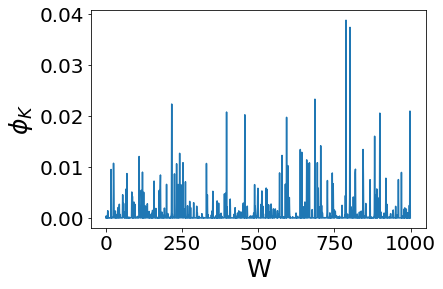

In [6]:
fig, ax = plt.subplots()

plt.plot(phi[0])

ax.set_xlabel("W", fontsize=25)
ax.set_ylabel("$\\phi_K$", fontsize=25)

ax.tick_params(labelsize=20)



In [7]:
theta = rng.dirichlet(np.repeat(beta, K), size=D)
assert(theta.shape==(D,K))

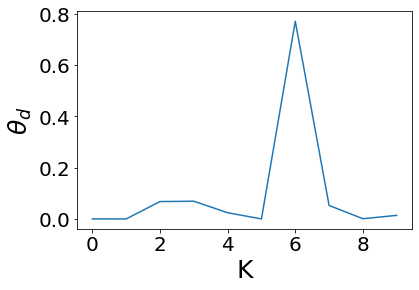

In [8]:
fig, ax = plt.subplots()

ax.plot(theta[0])

ax.set_xlabel("K", fontsize=25)
ax.set_ylabel("$\\theta_d$", fontsize=25)

ax.tick_params(labelsize=20)

plt.show()

In [120]:
z = np.array([[np.argmax(rng.multinomial(1, theta[i])) for j in range(Nd[i])]
     for i in range(D)])

In [121]:
z_bar = np.average(z, 1)
Ys = [[[rng.normal(eta*z_bar_d, sigma2) for _ in range(Nd[d])] for d,z_bar_d in enumerate(z_bar)] for _ in range(10)]

#non info 
#Ys = [[rng.uniform(0,50,size=Nd[d]) for d,z_bar_d in enumerate(z_bar)] for _ in range(10)]
Y = [rng.normal(eta*z_bar_d, sigma2) for z_bar_d in z_bar]
assert(len(Y)==D)

In [11]:
W = np.array([[np.argmax(rng.multinomial(1,phi[z[i,j]])) for j in range(Nd[i])]
     for i in range(D)])

In [12]:
W.shape

(250, 100)

In [13]:
df = pd.DataFrame()

for doc in range(D):
    doc_dict, doc_ab = np.unique(W[doc], return_counts=True)
    df = df.join(pd.Series(index=doc_dict, data=doc_ab, name="doc_{}".format(doc)), how="outer")
    

df = df.fillna(0).astype(int)

In [14]:
gamma = np.array([int(y) for y in Y])

In [15]:
df_meta = pd.DataFrame()


for doc in range(D):
    doc_dict, doc_ab = np.unique(gamma[doc], return_counts=True)
    df_meta = df_meta.join(pd.Series(index=doc_dict, data=doc_ab, name="doc_{}".format(doc)), how="outer")
    

df_meta = df_meta.fillna(0).astype(int)

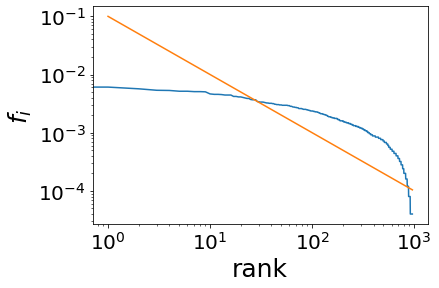

In [16]:
fig, ax = plt.subplots()

freq = df.sum(1).sort_values(ascending=False).values

ax.plot(freq/freq.sum())
ax.plot([1,len(freq)], [.1, .1/len(freq)])

ax.set_xlabel("rank", fontsize=25)
ax.set_ylabel("$f_i$", fontsize=25)

ax.tick_params(labelsize=20)

ax.set_xscale("log")
ax.set_yscale("log")

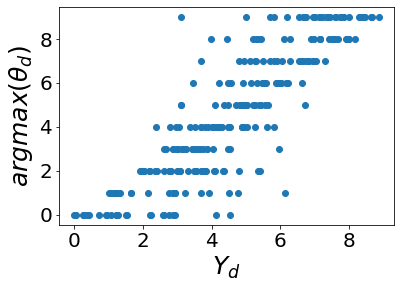

In [17]:
fig,ax=plt.subplots()

plt.scatter(Y,np.argmax(theta, axis=1))

ax.set_xlabel("$Y_d$", fontsize=25)
ax.set_ylabel("$argmax(\\theta_d)$", fontsize=25)

ax.tick_params(labelsize=20)

# Models
## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from scipy.special import kl_div

In [ ]:
lda = LatentDirichletAllocation(n_components=K)

In [ ]:
topic_dist = lda.fit_transform(df.transpose().values)

In [ ]:
fig, ax = plt.subplots()

ax.hist([np.sum(kl_div(topic_dist[i], theta[i])) for i in range(D)], density=True)


ax.set_xlabel("KL_divergence", fontsize=25)
ax.set_ylabel("pdf", fontsize=25)

ax.tick_params(labelsize=20)
plt.show()

## sLDA

In [ ]:
with open("train-data.txt", "w") as file:
    for doc in df.columns:
        total = (df[doc]>0).sum()
        file.write(str(total))
        for iw,(w,c) in enumerate(df[doc].items()):
            if c>0:
                file.write(f" {iw}:{c}")
        file.write("\n")

In [ ]:
with open("train-labels.txt", "w") as file:
    for y in Y:
        file.write(str(int(round(y,0)))+"\n")

## Run
```bash
slda est train-data.txt train-labels.txt settings.txt 0.01 10 random sldasyntetic
```

infer 

```bash
slda inf train-data.txt train-labels.txt settings.txt sldasyntetic/010.model sldasyntetic
```

### Postprocess

In [ ]:
import multiprocessing as mp

In [ ]:
slda_topic_dist = pd.read_csv("sldasyntetic/final.gamma", sep=" ", header=None)
slda_topic_dist.columns = ["Topic %d"%(t+1) for t in range(slda_topic_dist.shape[1])]
slda_topic_dist = slda_topic_dist.divide(slda_topic_dist.sum(1),0)
print(slda_topic_dist.shape)
slda_topic_dist.head(2)

In [ ]:
slda_word_dist = pd.DataFrame(index=df.index, columns = ["Topic %d"%(t+1) for t in range(10)]).fillna(0)
print(slda_word_dist.shape)
slda_word_dist.head(2)

In [ ]:
def assign_word(line, sample):
    new_sample = pd.Series(name=sample, index=slda_word_dist.index, dtype=object)
    for token in line:
        idx, cnt = token.split(":")
        new_sample.at[new_sample.index[int(idx)]]=int(cnt)
    return new_sample
    
def assign_doc(sample):
    global df_word_dist_temp
    df_word_dist_temp = df_word_dist_temp.join(sample, how="outer")

In [ ]:
pool = mp.Pool(6)
df_word_dist_temp = pd.DataFrame()
with open("sldasyntetic/word-assignments.dat") as file:
    lines = file.read().split("\n")      
    w = [pool.apply_async(assign_word, args=([line.split(" ")[1:], sample]), callback = assign_doc, error_callback=lambda err:log.error(err)) for line, sample in zip(lines, slda_word_dist.columns)]
    
    pool.close()

pool.join()
df_word_dist_temp=df_word_dist_temp.reindex(index=slda_word_dist.index, columns=slda_word_dist.columns)

In [ ]:
for g, data in df_word_dist_temp.apply(lambda x: np.unique(x[~x.isna()],return_counts=True), 1).items():
    for t, c in zip(*data):
        slda_word_dist.at[g,slda_word_dist.columns[t]]=c

In [ ]:
slda_word_dist = slda_word_dist.divide(slda_word_dist.sum(0),1).fillna(0)
slda_word_dist.head(2)

In [ ]:
with open("sldasyntetic/likelihood.dat") as file:
    slda_likelihood = float(file.readlines()[-1].split("\t")[0])

## hSBM

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/jovyan/work/phd/hSBM_Topicmodel/")
from sbmtm import sbmtm
import graph_tool.all as gt

In [ ]:
hsbm = sbmtm()

In [ ]:
hsbm.make_graph_from_BoW_df(df)

In [ ]:
hsbm.g

In [ ]:
hsbm.fit(n_init=3, B_min=8, B_max=15, parallel=True, verbose=False)

In [ ]:
gt.draw_hierarchy(hsbm.state,
                 layout="bipartite",
                 hedge_pen_width=8, 
                 hvertex_size=25, 
                 vertex_kind=hsbm.g.vertex_properties["kind"])

In [ ]:
import os
import cloudpickle as pickle

os.system("mkdir -p syntetic")
os.chdir("syntetic")
hsbm.save_data()
hsbm.save_graph()
os.chdir("..")

with open("sbmtm.pkl", "wb") as file:
    pickle.dump(hsbm, file)

## triSBM

In [20]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/jovyan/work/phd/trisbm/")
from trisbm import trisbm

In [ ]:
model = trisbm()

In [ ]:
df_meta.index = ["#{}".format(w) for w in df_meta.index]

In [ ]:
model.make_graph(df.append(df_meta), lambda w: 2 if "#" in str(w) else 1)

In [ ]:
model.fit(n_init=3, B_min=12, B_max=20, parallel=True, verbose=False)

In [ ]:
colmap = model.g.vertex_properties["color"] = model.g.new_vertex_property("vector<double>")
for v in model.g.vertices():
    k = model.g.vertex_properties['kind'][v]
    if k < 1:
        color = np.array([137,128,193])/255.
    elif k < 2:
        color = np.array([130,200,93])/255.
    elif k < 3:
        color = np.array([210,82,58])/255.
    else:
        color = np.array([114,124,206])/255.
    colmap[v] = color

In [ ]:
gt.draw_hierarchy(model.state,
                 hedge_pen_width=8, 
                 hvertex_size=25, 
                 vertex_color=colmap,
                 vertex_fill_color=colmap
                 )

In [ ]:
import os
import cloudpickle as pickle

os.system("mkdir -p syntetic_key")
os.chdir("syntetic_key")
model.save_data()
model.save_graph()
os.chdir("..")

with open("trisbm.pkl", "wb") as file:
    pickle.dump(model, file)

# Scalings

In [129]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.optimize import curve_fit

In [122]:
df_meta_list = []

for i_branch in range(len(Ys)):
    df_meta = pd.DataFrame()
    for doc in range(D):
        doc_dict, doc_ab = np.unique(np.array(Ys[i_branch], dtype=int)[doc], return_counts=True)
        df_meta = df_meta.join(pd.Series(index=doc_dict, data=doc_ab, name="doc_{}".format(doc)), how="outer")
    df_meta = df_meta.fillna(1).astype(int)
    df_meta_list.append(df_meta)

In [123]:
results = []
for i in range(1,len(df_meta_list)-1):
    model = trisbm()
    model.make_graph_multiple_df(df, df_meta_list[:i])
    g = model.g
    vp = model.g.new_vertex_property("int")
    for v in model.g.vertices():
        vp[v]=v
        
    results.append((i, g.num_edges(), g.num_vertices(), gt.BlockState(model.g, b=model.g.vp["kind"]).entropy(), gt.BlockState(model.g, b=vp).entropy()))
    del model
    gc.collect()

In [124]:
df_scalings = pd.DataFrame(columns=["layer", "E", "V", "sigma1", "sigmaN"], data = results)
df_scalings.to_csv("scalings.csv", index=None)

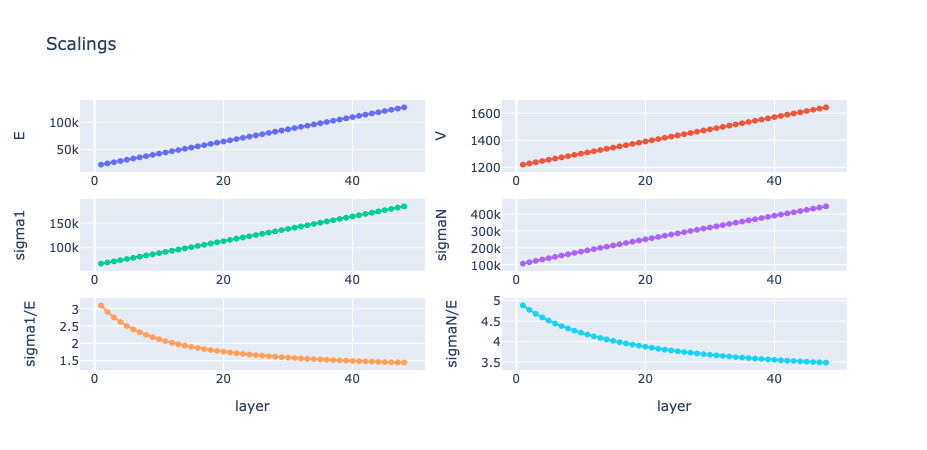

In [153]:
plots = [[("layer","E",None),("layer","V",None)],
         [("layer","sigma1",None),("layer","sigmaN",None)], 
         [("layer","sigma1","E"),("layer","sigmaN","E")]]

nrows, ncols = np.shape(plots)[:2]
fig = make_subplots(rows=nrows, cols=ncols, shared_xaxes = False)


assert(len(plots) <= nrows * ncols)

for i, (x, y, z) in enumerate(np.reshape(plots,(-1,3))):
    
    row = int((i / ncols) + 1 )
    col = int((i % ncols) + 1 )
    
    y_data = df_scalings[y]
    y_label = y
    
    if z is not None:
        y_data = df_scalings[y] / df_scalings[z]
        y_label = y + "/" + z
    
    fig.add_trace(
        go.Scatter(x = df_scalings[x], y = y_data, mode="markers+lines", name=""),
        row=row, col=col
    )

    fig.update_yaxes(title=y_label, row=row, col=col)
    
for icol in range(ncols):
    fig.update_xaxes(title="layer", row=3, col=icol+1)

fig.update_layout(title="Scalings", showlegend=False)

fig.show()
fig.write_image("scalings_l.pdf", engine="kaleido")

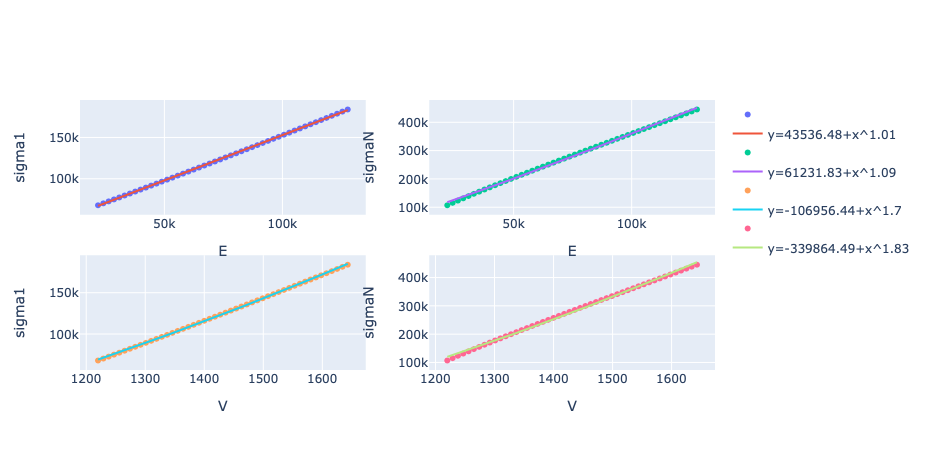

In [154]:
plots = [[("E", "sigma1"),("E", "sigmaN")],
        [("V", "sigma1"),("V", "sigmaN")]]

nrows, ncols = np.shape(plots)[:2]
fig = make_subplots(rows=nrows, cols=ncols, shared_xaxes = False)

for i, (x_label, y_label) in enumerate(np.reshape(plots,(-1,2))): 
    
    row = int((i / ncols) + 1 )
    col = int((i % ncols) + 1 )

    x = df_scalings[x_label]
    y = df_scalings[y_label]

    fit_func = lambda x, a, b: a+np.power(x,b)

    popt, pcov = curve_fit(fit_func, x, y)

    fig.add_trace(go.Scatter(x = x, y = y, name="", mode="markers"), row=row, col=col)
    fig.add_trace(go.Scatter(x = x, y = fit_func(x,*popt), name="y={}+x^{}".format(*np.round(popt,2)), mode="lines"), row=row, col=col)

    fig.update_xaxes(title=x_label, row=row, col=col)
    fig.update_yaxes(title=y_label, row=row, col=col)

fig.update_layout(
    #xaxis1_type="log",
    #yaxis1_type="log",
    
    #xaxis2_type="log",
    #yaxis2_type="log",
)

fig.show()
fig.write_image("scalings_scatter.pdf", engine="kaleido")

# Benchmark

## Add layers

In [ ]:
df_meta_list = []

for i_branch in range(len(Ys)):
    df_meta = pd.DataFrame()
    for doc in range(D):
        doc_dict, doc_ab = np.unique(np.array(Ys[i_branch], dtype=int)[doc], return_counts=True)
        df_meta = df_meta.join(pd.Series(index=doc_dict, data=doc_ab, name="doc_{}".format(doc)), how="outer")
    df_meta = df_meta.fillna(1).astype(int)
    df_meta_list.append(df_meta)

In [ ]:
df_meta_list[0].head()

In [ ]:
results = []
for i in range(1,len(df_meta_list)-1):
    #print(i,len(df_meta_list[:i]))
    model = trisbm()
    model.make_graph_multiple_df(df, df_meta_list[:i])
    vp=model.g.new_vertex_property("int")
    for v in model.g.vertices():
        vp[v]=v
        
    model.fit(n_init=3, B_min=10, parallel=True, verbose=False)
    results.append((i, model.get_mdl(), model.state.entropy(dl=False), model.g.num_edges(),gt.BlockState(model.g, b=model.g.vp["kind"]).entropy(), gt.BlockState(model.g, b=vp).entropy()))
    #model.draw(hedge_pen_width=8, hvertex_size=25)
    del model
    gc.collect()

In [ ]:
df_N_entropies = pd.DataFrame(data=results, columns=["N","sigma","S","E","sigma1","sigmaN"])
df_N_entropies["sigma2"]=sigma2
#df_N_entropies.to_csv("N_entropies.csv", index=False)
pd.read_csv("N_entropies.csv").append(df_N_entropies).to_csv("N_entropies.csv", index=False)

In [ ]:
entropies_N = pd.read_csv("N_entropies.csv")

fig = go.Figure()

Es = entropies_N.groupby("N").mean()["E"].values
infs = entropies_N[entropies_N["sigma2"]==np.inf]["sigma"].values

for _sigma2 in np.sort(entropies_N["sigma2"].unique()):
    subset = entropies_N[entropies_N["sigma2"]==_sigma2]
    fig.add_trace(
        go.Scatter(x=subset["N"], y=subset["sigma"]/Es, marker={"size":25}, line={"width":10}, name=_sigma2)
    )

fig.update_layout({"xaxis":{
        "tickfont":{
            "size":25
        },
        "title":"N appended branches",
        "titlefont_size":25,
    },
     "yaxis":{
        "title":"∑/E",
        "type":"log",
        "titlefont_size":25,
         "tickfont":{
            "size":25
        }
    }
}
)
fig.show()
fig.write_image("entropies_NE.pdf")

### Store entropies

In [ ]:
#pd.DataFrame(columns = ["sigma2", "lda", "slda", "hsbm", "E", "trisbm", "triE"]).to_csv("sigma_entropies.csv", index=False)

In [ ]:
file = "sigma_entropies.csv"
pd.read_csv(file).append(
    pd.DataFrame(columns = ["sigma2", "lda", "slda", "hsbm", "E", "trisbm", "triE"],
                        data= [[
                            sigma2,
                            -lda.score(df.transpose().values),
                            -slda_likelihood,
                            hsbm.state.entropy(),
                            hsbm.g.num_edges(),
                            model.state.entropy,
                            model.g.num_edges()
                        ]])
).to_csv(file, index=False)

## Entropy

In [ ]:
df_seeds = pd.read_csv("seed_entropies.csv")
df_seeds["lda_e"] = df_seeds["lda"]/df_seeds["E"]
df_seeds["slda_e"] = df_seeds["slda"]/df_seeds["triE"]
df_seeds["hsbm_e"] = df_seeds["hsbm"]/df_seeds["E"]
df_seeds["trisbm_e"] = df_seeds["trisbm"]/df_seeds["triE"]
entropies = df_seeds.mean(0)
entropies_errors = df_seeds.apply(lambda s: (s.max()-s.min())/2., axis=0)

In [ ]:
for alg in ["lda_e", "slda_e", "hsbm_e", "trisbm_e"]:
    print(alg.split("_")[0]," & ",round(entropies[alg],2),"+-",round(entropies_errors[alg],2))

In [ ]:
fig = go.Figure()

fig.add_traces([
    go.Bar(x=[0], y=[entropies["lda_e"]], name="lda", error_y={"type":"data", "array":[entropies_errors["lda_e"]]}),
    go.Bar(x=[1], y=[entropies["slda_e"]], name="slda", error_y={"type":"data", "array":[entropies_errors["slda_e"]]}),
    go.Bar(x=[2], y=[entropies["hsbm_e"]], name="hsbm", error_y={"type":"data", "array":[entropies_errors["hsbm_e"]]}),
    go.Bar(x=[3], y=[entropies["trisbm_e"]], name="trisbm", error_y={"type":"data", "array":[entropies_errors["trisbm_e"]]})
])
    
fig.update_layout(
{
    "xaxis":{
        "tickfont":{
            "size":25
        },
        "tickmode": "array",
        "tickvals": [0,1,2,3],
        "ticktext": ["lda", "slda", "hsbm", "trisbm"],
    },
     "yaxis":{
        "title":"-Log-Likelihood (per edge)",
        "titlefont_size":25,
         "tickfont":{
            "size":25
        },
        #"range":[3,3.35]
    }
}
)
fig.show()
fig.write_image("sigma_topics.pdf", engine="kaleido")

## Entropy vs param

### K

In [ ]:
df_K = pd.read_csv("topic_entropies.csv").sort_values(by="K")
df_K["lda_e"] = df_K["lda"]/df_K["E"]
df_K["slda_e"] = df_K["slda"]/df_K["triE"]
df_K["hsbm_e"] = df_K["hsbm"]/df_K["E"]
df_K["trisbm_e"] = df_K["trisbm"]/df_K["triE"]

In [ ]:
fig = go.Figure()

lw=4

ms = {
    "size":10
}

fig.add_traces(
[
    #go.Scatter(x = df_K["K"], y=df_K["lda_e"], name = "lda", line=ls, marker=ms),
    #go.Scatter(x = df_K["K"], y=df_K["slda_e"], name = "slda", line=ls, marker=ms),
    go.Scatter(x = df_K["K"], y=df_K["hsbm_e"], line={"color":"#00CC96", "width":lw}, error_y={"type":"percent", "value":0.01/3.29*100, "visible":True}, name = "hsbm", marker=ms),
    go.Scatter(x = df_K["K"], y=df_K["trisbm_e"],line={"color":"#AB63FA", "width":lw}, error_y={"type":"percent", "value":0.01/3.21*100, "visible":True}, name = "trisbm", marker=ms)
])

fig.update_layout(
{
    "xaxis":{
        "title":"Number of topics, K",
         "tickfont":{
            "size":25
        },
        "titlefont_size":25
    },
    "yaxis":{
        #"type":"log",
        "title":"∑/E",
         "titlefont":{
            "size":25
        },
         "tickfont":{
            "size":25
        },
        #"range":[2.5,6]
    }
})

fig.show()

fig.write_image("K_entropies.pdf")

### sigma

In [ ]:
df_K = pd.read_csv("sigma_entropies.csv").sort_values(by="sigma2")

In [ ]:
fig = go.Figure()


ms = {
    "size":20
}

#['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

fig.add_traces(
[
    go.Scatter(x = df_K["sigma2"], y=df_K["slda"], name = "slda", line={"color":"#EF553B", "width":8}, marker=ms),
    go.Scatter(x = df_K["sigma2"], y=df_K["trisbm"], name = "trisbm", line={"color":"#AB63FA", "width":8}, marker=ms)
])

fig.update_layout(
{
    "xaxis":{
        "type":"log",
        "title":"sigma^2",
         "tickfont":{
            "size":25
        },
        "titlefont_size":25
    },
    "yaxis":{
        "title":"∑/E",
         "titlefont":{
            "size":25
        },
         "tickfont":{
            "size":25
        },
    }
})

fig.show()

fig.write_image("sigma_entropies.pdf")

## Distributions
### Topic dist

In [ ]:
hsbm_dist = pd.read_csv("syntetic/topsbm_level_0_topic-dist.csv", index_col=1).drop("i_doc",1)

In [ ]:
trisbm_dist = pd.read_csv("syntetic_key/trisbm_level_0_topic-dist.csv", index_col=1).drop("i_doc",1)

In [ ]:
import seaborn as sns

In [ ]:
def padding(a,b, epsilon = 0):
    la = len(a)
    lb = len(b)
    if la>lb:
        return a+epsilon,np.concatenate((b,np.zeros(la-lb)))+epsilon
    elif la<lb:
        return np.concatenate((a,np.zeors(lb-la)))+epsilon,b+epsilon
    return a+epsilon,b+epsilon

In [ ]:
real_hsbm_kl = [np.sum(kl_div(*padding(theta[idoc], hsbm_dist.values[idoc], 1e-10))) for idoc in range(D)]

real_tri_kl = [np.sum(kl_div(*padding(theta[idoc], trisbm_dist.values[idoc], 1e-10))) for idoc in range(D)]

real_lda_kl = [np.sum(kl_div(*padding(theta[idoc], topic_dist[idoc], 1e-10))) for idoc in range(D)]

real_slda_kl = [np.sum(kl_div(*padding(theta[idoc], slda_topic_dist.values[idoc], 1e-10))) for idoc in range(D)]

In [ ]:
fig = go.Figure()

def get_scatter(data, name):
    hist = np.histogram(data, density=True)

    return go.Scatter(x=(hist[1][1:]+hist[1][:-1])/2, 
                      y=hist[0], 
                      mode="lines", 
                      line={"shape":"hvh", "width":8}, 
                      name=name)
    
fig.add_traces([
    get_scatter(data, name)
    
    for data, name in zip([real_hsbm_kl, real_tri_kl, real_lda_kl, real_slda_kl],
                         ["hsbm", "trisbm", "lda", "slda"])
])
    
fig.update_layout(
{
    "xaxis":{
        "title":"KL (P(topic|sample),P(planted latent variable|sample))",
        "titlefont_size":25
    },
     "yaxis":{
        "title":"documents",
        "titlefont_size":25
    },
    "barmode":'overlay'
}
)
fig.update_traces(opacity=0.5)
fig.show()
fig.write_image("KL_topics.pdf", engine="kaleido")

### Word-dist

In [ ]:
hsbm_word_dist = pd.read_csv("syntetic/topsbm_level_0_word-dist.csv", index_col=0)

In [ ]:
trisbm_word_dist = pd.read_csv("syntetic_key/trisbm_level_0_word-dist.csv", index_col=0)

In [ ]:
lda_word_dist = lda.components_.T
lda_word_dist = lda_word_dist/np.sum(lda_word_dist, axis=0)

In [ ]:
real_hsbm_kl_words = [[np.sum(kl_div(*padding(phi[ilatent], hsbm_word_dist.values.T[itopic], 1e-10))) for ilatent in range(K)]
 for itopic in range(hsbm_word_dist.shape[1])]

real_tri_kl_words = [[np.sum(kl_div(*padding(phi[ilatent], trisbm_word_dist.values.T[itopic], 1e-10))) for ilatent in range(K)]
 for itopic in range(trisbm_word_dist.shape[1])]

real_lda_kl_words = [[np.sum(kl_div(*padding(phi[ilatent], lda_word_dist.T[itopic], 1e-10))) for ilatent in range(K)]
 for itopic in range(lda_word_dist.shape[1])]

real_slda_kl_words = [[np.sum(kl_div(*padding(phi[ilatent], slda_word_dist.values.T[itopic], 1e-10))) for ilatent in range(K)]
 for itopic in range(slda_word_dist.shape[1])]

In [ ]:
sns.heatmap(np.sort(real_lda_kl_words, axis=1))

In [ ]:
sns.heatmap(np.sort(real_tri_kl_words, axis=1))

In [ ]:
fig = go.Figure()

fig.add_traces([
    go.Histogram(x=np.ravel(real_hsbm_kl_words), name="hsbm"),
    go.Histogram(x=np.ravel(real_tri_kl_words), name="trisbm"),
    go.Histogram(x=np.ravel(real_lda_kl_words), name="lda"),
    go.Histogram(x=np.ravel(real_slda_kl_words), name="slda")
])
    
fig.update_layout(
{
    "xaxis":{
        "title":"KL (P(word|topic),P(word|planted variable))",
        "titlefont_size":25
    },
     "yaxis":{
        "title":"pait topic-latent variable",
        "titlefont_size":25
    },
    "barmode":'overlay'
}
)
fig.update_traces(opacity=0.3)
fig.show()
fig.write_image("KL_words.pdf", engine="kaleido")

### Y

In [ ]:
with open("sldasyntetic/inf-labels.dat") as file:
    slda_labels = list(map(lambda row: int(row.split("\n")[0]),file.readlines()))

In [ ]:
trisbm_labels = pd.read_csv("syntetic_key/trisbm_level_0_kind_2_metadatum-dist.csv").drop("i_doc",1).set_index("doc").apply(np.argmax,1)

In [ ]:
fig,ax=plt.subplots()


plt.scatter(Y, trisbm_labels, color="blue", label="trisbm")
plt.scatter(Y, slda_labels, color="purple", label="slda")

ax.set_xlabel("$Y_d$", fontsize=25)
ax.set_ylabel("$Y_d inferred$", fontsize=25)

ax.legend()

ax.tick_params(labelsize=20)